# Error Analysis with Probabilities

Classification error analysis using probabilities:
- Confusion Matrix with probabilities
- Analysis of errors with high confidence (>0.8)
- Analysis of errors with low confidence (<0.6)
- Probability distribution for correct and incorrect predictions
- Analysis by phonemes


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import json

# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name in ['notebooks', 'b-p_first_experiments'] else Path.cwd()
OUTPUT_DIR = PROJECT_ROOT / 'artifacts' / 'b-p_dl_models' / 'improved_models' / 'hybrid_cnn_mlp_v3'

# Load predictions
predictions_df = pd.read_csv(OUTPUT_DIR / 'test_predictions_with_probs.csv')
print(f"Loaded {len(predictions_df)} predictions")
print(f"\nColumns: {predictions_df.columns.tolist()}")
print(f"\nFirst few rows:")
predictions_df.head()


Loaded 5349 predictions

Columns: ['phoneme_id', 'utterance_id', 'phoneme', 'true_class', 'true_class_encoded', 'predicted_class_encoded', 'predicted_class', 'prob_class_0', 'prob_class_1', 'max_prob', 'is_correct', 'confidence', 'duration_ms']

First few rows:


,phoneme_id,utterance_id,phoneme,true_class,true_class_encoded,predicted_class_encoded,predicted_class,prob_class_0,prob_class_1,max_prob,is_correct,confidence,duration_ms
0,4aeeae88-0777-2c8c-5c93-2e844a462e49---d9f596c...,4aeeae88-0777-2c8c-5c93-2e844a462e49---d9f596c...,b,b,0,0,b,0.924223,0.075777,0.924223,1,0.924223,NaN
1,4aeeae88-0777-2c8c-5c93-2e844a462e49---31937f8...,4aeeae88-0777-2c8c-5c93-2e844a462e49---31937f8...,b,b,0,0,b,0.924554,0.075446,0.924554,1,0.924554,NaN
2,4aeeae88-0777-2c8c-5c93-2e844a462e49---98cf8b3...,4aeeae88-0777-2c8c-5c93-2e844a462e49---98cf8b3...,b,b,0,0,b,0.914656,0.085344,0.914656,1,0.914656,NaN
3,4aeeae88-0777-2c8c-5c93-2e844a462e49---efcbe00...,4aeeae88-0777-2c8c-5c93-2e844a462e49---efcbe00...,b,b,0,0,b,0.905213,0.094787,0.905213,1,0.905213,NaN
4,4aeeae88-0777-2c8c-5c93-2e844a462e49---191f418...,4aeeae88-0777-2c8c-5c93-2e844a462e49---191f418...,p,p,1,1,p,0.044180,0.955820,0.955820,1,0.955820,NaN


## 1. Confusion Matrix with Probabilities


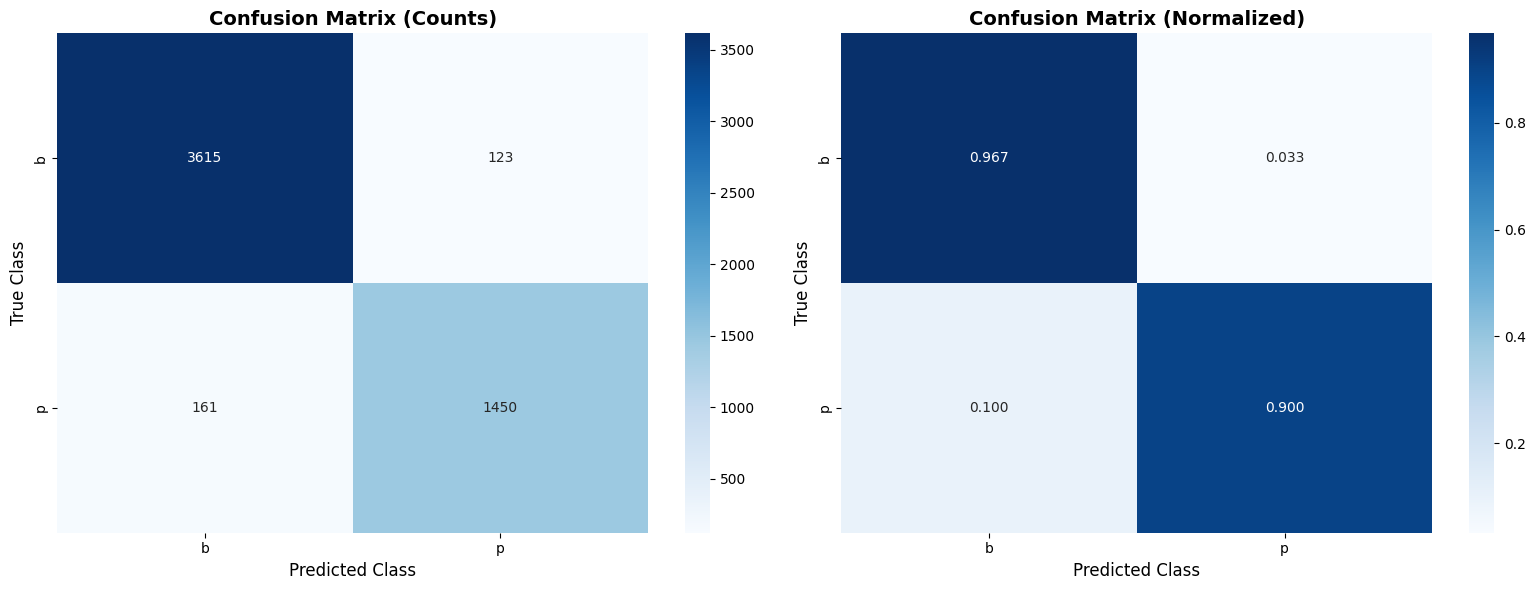

Confusion Matrix:
True b -> Predicted b: 3615
True b -> Predicted p: 123
True p -> Predicted b: 161
True p -> Predicted p: 1450


In [2]:
# Create confusion matrix
cm = confusion_matrix(predictions_df['true_class_encoded'], predictions_df['predicted_class_encoded'])
class_names = ['b', 'p']

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Standard confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Class', fontsize=12)
axes[0].set_xlabel('Predicted Class', fontsize=12)

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.3f', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Class', fontsize=12)
axes[1].set_xlabel('Predicted Class', fontsize=12)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion Matrix:")
print(f"True b -> Predicted b: {cm[0, 0]}")
print(f"True b -> Predicted p: {cm[0, 1]}")
print(f"True p -> Predicted b: {cm[1, 0]}")
print(f"True p -> Predicted p: {cm[1, 1]}")


## 2. Analysis of Incorrect Predictions with Probabilities


In [3]:
# Get incorrect predictions
incorrect = predictions_df[predictions_df['is_correct'] == 0].copy()
print(f"Total incorrect predictions: {len(incorrect)}")
print(f"Percentage of all predictions: {len(incorrect) / len(predictions_df) * 100:.2f}%")

# Categorize errors by confidence
high_conf_errors = incorrect[incorrect['confidence'] > 0.8]
medium_conf_errors = incorrect[(incorrect['confidence'] >= 0.6) & (incorrect['confidence'] <= 0.8)]
low_conf_errors = incorrect[incorrect['confidence'] < 0.6]

print(f"\nError distribution by confidence:")
print(f"- High confidence errors (>0.8): {len(high_conf_errors)} ({len(high_conf_errors)/len(incorrect)*100:.1f}%)")
print(f"- Medium confidence errors (0.6-0.8): {len(medium_conf_errors)} ({len(medium_conf_errors)/len(incorrect)*100:.1f}%)")
print(f"- Low confidence errors (<0.6): {len(low_conf_errors)} ({len(low_conf_errors)/len(incorrect)*100:.1f}%)")

# Statistics
print(f"\nConfidence statistics for incorrect predictions:")
print(f"- Mean: {incorrect['confidence'].mean():.4f}")
print(f"- Median: {incorrect['confidence'].median():.4f}")
print(f"- Min: {incorrect['confidence'].min():.4f}")
print(f"- Max: {incorrect['confidence'].max():.4f}")
print(f"- Std: {incorrect['confidence'].std():.4f}")


Total incorrect predictions: 284
Percentage of all predictions: 5.31%

Error distribution by confidence:
- High confidence errors (>0.8): 153 (53.9%)
- Medium confidence errors (0.6-0.8): 95 (33.5%)
- Low confidence errors (<0.6): 36 (12.7%)

Confidence statistics for incorrect predictions:
- Mean: 0.7870
- Median: 0.8276
- Min: 0.5036
- Max: 0.9610
- Std: 0.1342


## 3. High Confidence Errors (Systematic Issues)


In [4]:
if len(high_conf_errors) > 0:
    print(f"High confidence errors (>0.8): {len(high_conf_errors)}")
    print("\nThese are systematic issues - model is very confident but wrong!")
    print("\nError breakdown by true/predicted class:")
    print(high_conf_errors.groupby(['true_class', 'predicted_class']).size())
    
    print("\nTop phonemes with high confidence errors:")
    phoneme_errors = high_conf_errors.groupby('phoneme').agg({
        'phoneme_id': 'count',
        'confidence': ['mean', 'min', 'max']
    }).sort_values(('phoneme_id', 'count'), ascending=False)
    phoneme_errors.columns = ['count', 'mean_conf', 'min_conf', 'max_conf']
    print(phoneme_errors.head(20))
    
    # Save high confidence errors
    high_conf_errors.to_csv(OUTPUT_DIR / 'high_confidence_errors.csv', index=False)
    print(f"\nSaved high confidence errors to: {OUTPUT_DIR / 'high_confidence_errors.csv'}")
else:
    print("No high confidence errors found!")


High confidence errors (>0.8): 153

These are systematic issues - model is very confident but wrong!

Error breakdown by true/predicted class:
true_class  predicted_class
b           p                  66
p           b                  87
dtype: int64

Top phonemes with high confidence errors:
         count  mean_conf  min_conf  max_conf
phoneme                                      
p           87   0.883950  0.800962  0.922666
b           66   0.908945  0.800629  0.961037

Saved high confidence errors to: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/improved_models/hybrid_cnn_mlp_v3/high_confidence_errors.csv


## 4. Low Confidence Errors (Borderline Cases)


In [5]:
if len(low_conf_errors) > 0:
    print(f"Low confidence errors (<0.6): {len(low_conf_errors)}")
    print("\nThese are borderline cases - model is uncertain, which is expected.")
    print("\nError breakdown by true/predicted class:")
    print(low_conf_errors.groupby(['true_class', 'predicted_class']).size())
    
    print("\nTop phonemes with low confidence errors:")
    phoneme_errors = low_conf_errors.groupby('phoneme').agg({
        'phoneme_id': 'count',
        'confidence': ['mean', 'min', 'max']
    }).sort_values(('phoneme_id', 'count'), ascending=False)
    phoneme_errors.columns = ['count', 'mean_conf', 'min_conf', 'max_conf']
    print(phoneme_errors.head(20))
    
    # Save low confidence errors
    low_conf_errors.to_csv(OUTPUT_DIR / 'low_confidence_errors.csv', index=False)
    print(f"\nSaved low confidence errors to: {OUTPUT_DIR / 'low_confidence_errors.csv'}")
else:
    print("No low confidence errors found!")


Low confidence errors (<0.6): 36

These are borderline cases - model is uncertain, which is expected.

Error breakdown by true/predicted class:
true_class  predicted_class
b           p                  16
p           b                  20
dtype: int64

Top phonemes with low confidence errors:
         count  mean_conf  min_conf  max_conf
phoneme                                      
p           20   0.542784  0.503625  0.592131
b           16   0.556258  0.506924  0.596849

Saved low confidence errors to: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/improved_models/hybrid_cnn_mlp_v3/low_confidence_errors.csv


## 5. Probability Distribution Analysis


/var/folders/hg/7_xt468j3nz1xqspwcc6s8jw0000gn/T/ipykernel_84587/1706772187.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0, 1].boxplot(data_for_box, labels=['Correct', 'Incorrect'])


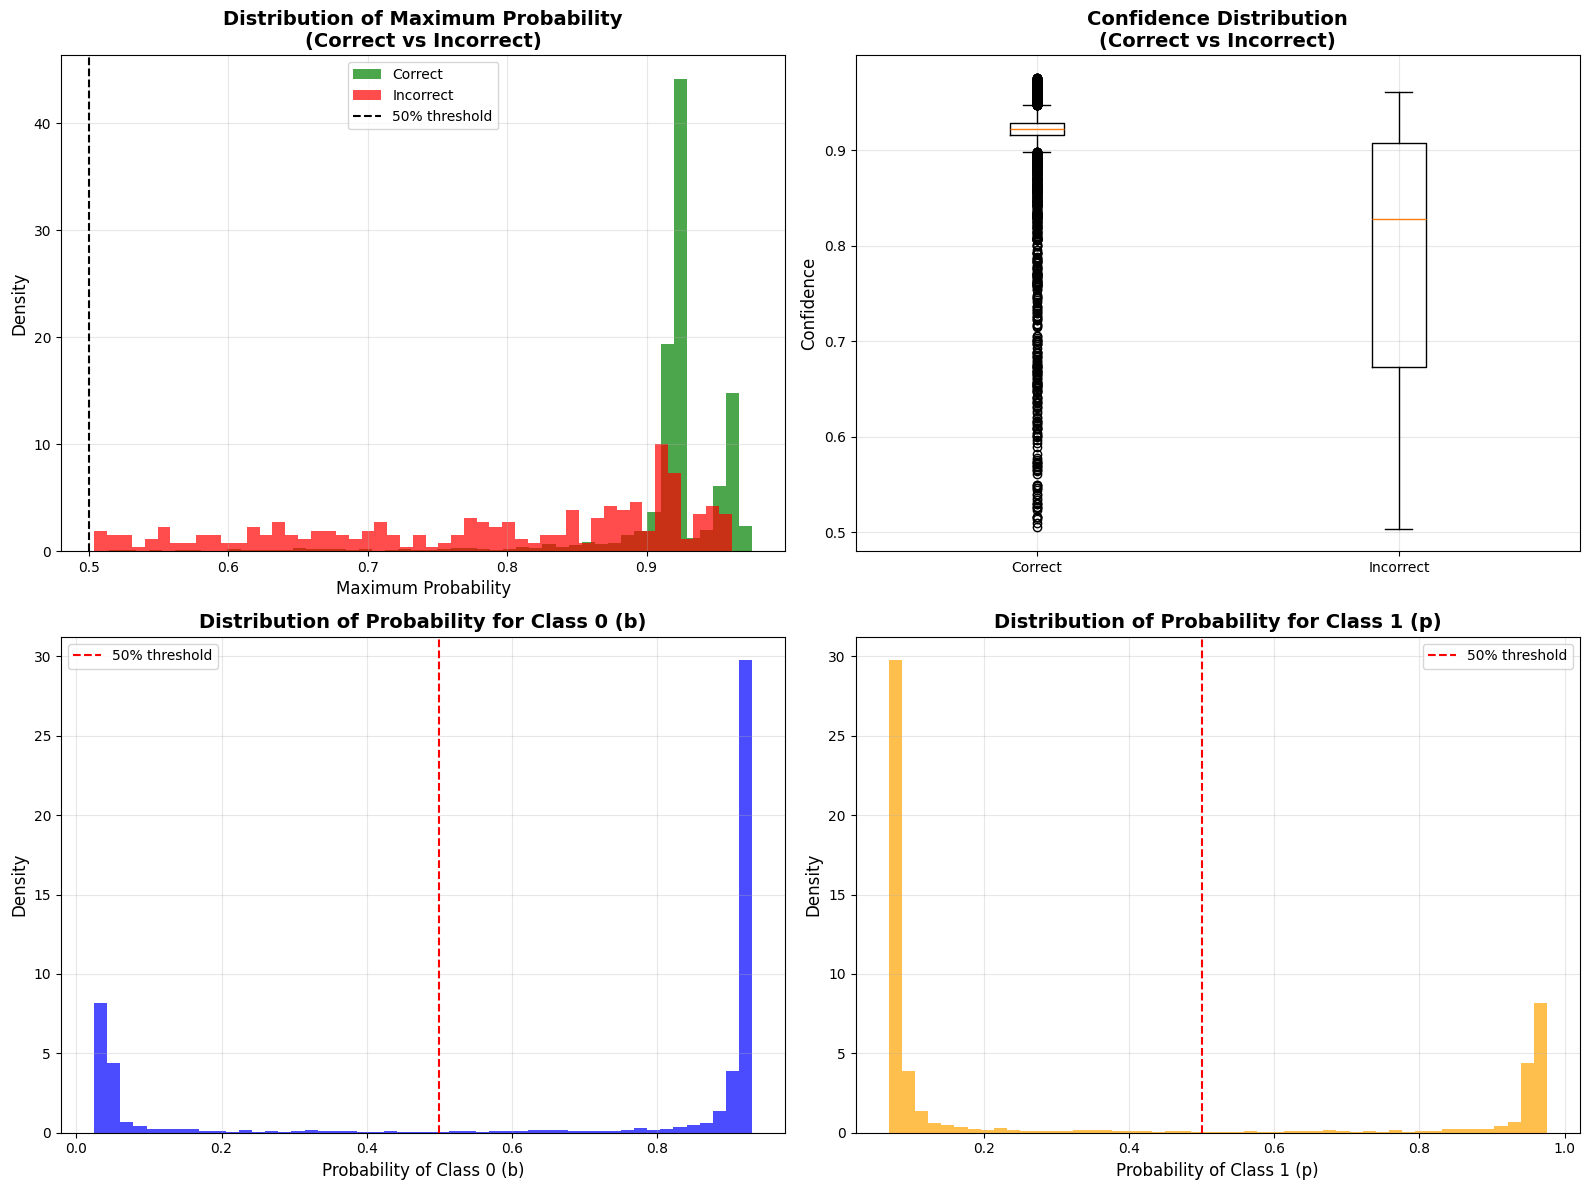

In [6]:
# Create probability distribution plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of max probability for correct vs incorrect
correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob']
incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob']

axes[0, 0].hist(correct_probs, bins=50, alpha=0.7, label='Correct', color='green', density=True)
axes[0, 0].hist(incorrect_probs, bins=50, alpha=0.7, label='Incorrect', color='red', density=True)
axes[0, 0].axvline(0.5, color='black', linestyle='--', label='50% threshold')
axes[0, 0].set_xlabel('Maximum Probability', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].set_title('Distribution of Maximum Probability\n(Correct vs Incorrect)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Box plot of confidence by correctness
data_for_box = [
    predictions_df[predictions_df['is_correct'] == 1]['confidence'].values,
    predictions_df[predictions_df['is_correct'] == 0]['confidence'].values
]
axes[0, 1].boxplot(data_for_box, labels=['Correct', 'Incorrect'])
axes[0, 1].set_ylabel('Confidence', fontsize=12)
axes[0, 1].set_title('Confidence Distribution\n(Correct vs Incorrect)', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# 3. Probability distribution for class 0 (b)
axes[1, 0].hist(predictions_df['prob_class_0'], bins=50, alpha=0.7, color='blue', density=True)
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='50% threshold')
axes[1, 0].set_xlabel('Probability of Class 0 (b)', fontsize=12)
axes[1, 0].set_ylabel('Density', fontsize=12)
axes[1, 0].set_title('Distribution of Probability for Class 0 (b)', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Probability distribution for class 1 (p)
axes[1, 1].hist(predictions_df['prob_class_1'], bins=50, alpha=0.7, color='orange', density=True)
axes[1, 1].axvline(0.5, color='red', linestyle='--', label='50% threshold')
axes[1, 1].set_xlabel('Probability of Class 1 (p)', fontsize=12)
axes[1, 1].set_ylabel('Density', fontsize=12)
axes[1, 1].set_title('Distribution of Probability for Class 1 (p)', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'probability_distributions.png', dpi=300, bbox_inches='tight')
plt.show()


## 6. Error Analysis by Phoneme


Phoneme Error Analysis (sorted by error rate):
         total  correct_count  accuracy  mean_conf  min_conf  max_conf  \
phoneme                                                                  
p         1611           1450    0.9001     0.9203    0.5036    0.9759   
b         3738           3615    0.9671     0.9032    0.5054    0.9610   

         std_conf  mean_prob_b  mean_prob_p  error_count  error_rate  
phoneme                                                               
p          0.0906       0.1361       0.8639          161      0.0999  
b          0.0594       0.8839       0.1161          123      0.0329  

Saved phoneme analysis to: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dl_models/improved_models/hybrid_cnn_mlp_v3/phoneme_error_analysis.csv


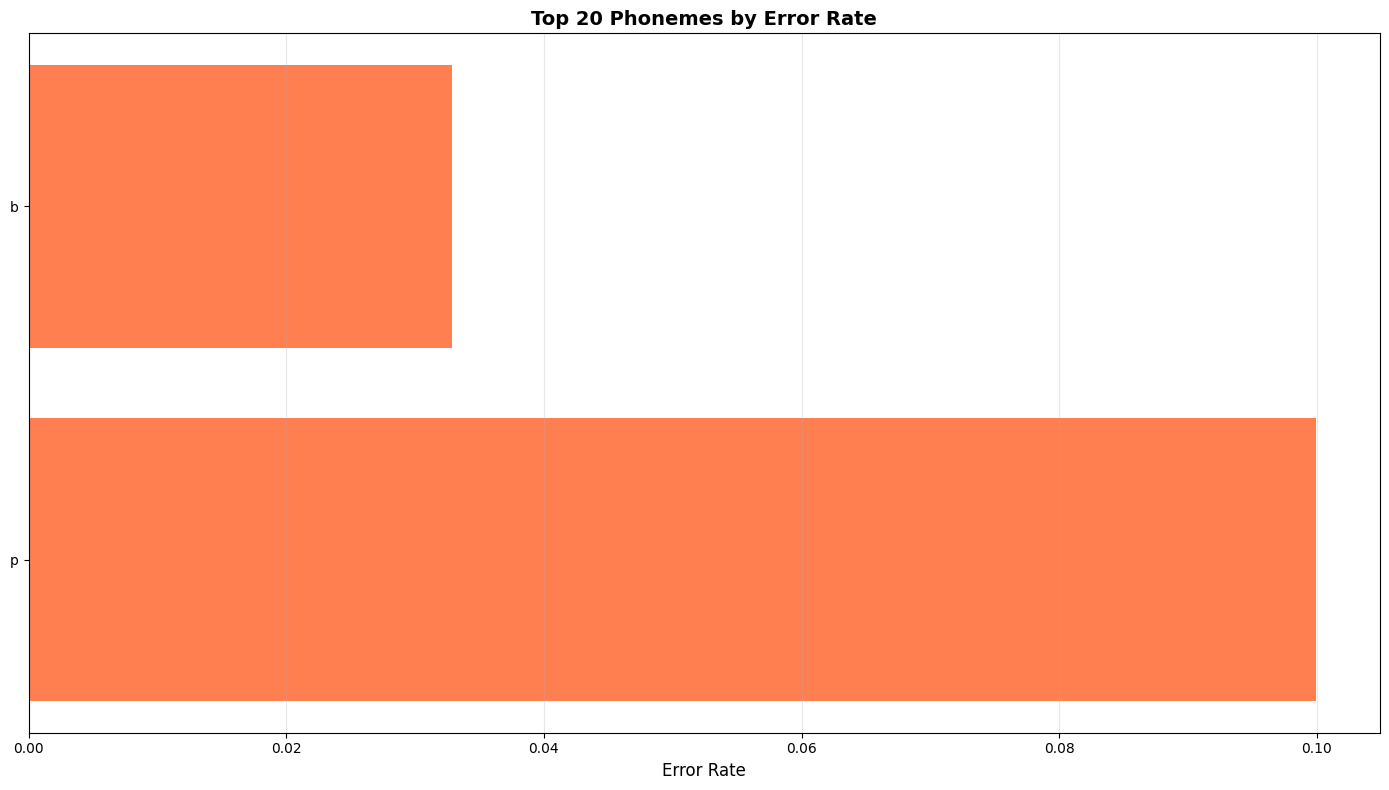

In [7]:
# Analyze errors by phoneme
phoneme_analysis = predictions_df.groupby('phoneme').agg({
    'phoneme_id': 'count',
    'is_correct': ['sum', 'mean'],
    'confidence': ['mean', 'min', 'max', 'std'],
    'prob_class_0': 'mean',
    'prob_class_1': 'mean'
}).round(4)

phoneme_analysis.columns = ['total', 'correct_count', 'accuracy', 'mean_conf', 'min_conf', 'max_conf', 'std_conf', 'mean_prob_b', 'mean_prob_p']
phoneme_analysis['error_count'] = phoneme_analysis['total'] - phoneme_analysis['correct_count']
phoneme_analysis['error_rate'] = 1 - phoneme_analysis['accuracy']

# Sort by error rate
phoneme_analysis = phoneme_analysis.sort_values('error_rate', ascending=False)

print("Phoneme Error Analysis (sorted by error rate):")
print(phoneme_analysis.head(30))

# Save phoneme analysis
phoneme_analysis.to_csv(OUTPUT_DIR / 'phoneme_error_analysis.csv')
print(f"\nSaved phoneme analysis to: {OUTPUT_DIR / 'phoneme_error_analysis.csv'}")

# Plot top phonemes with highest error rates
top_errors = phoneme_analysis.head(20)
fig, ax = plt.subplots(figsize=(14, 8))
ax.barh(range(len(top_errors)), top_errors['error_rate'], color='coral')
ax.set_yticks(range(len(top_errors)))
ax.set_yticklabels(top_errors.index)
ax.set_xlabel('Error Rate', fontsize=12)
ax.set_title('Top 20 Phonemes by Error Rate', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'top_phoneme_errors.png', dpi=300, bbox_inches='tight')
plt.show()


## 7. Detailed Error Cases


In [8]:
# Show detailed error cases
display_cols = ['phoneme', 'true_class', 'predicted_class', 'prob_class_0', 'prob_class_1', 'confidence', 'duration_ms']

print("Sample of incorrect predictions:")
print("\nHigh confidence errors (most concerning):")
if len(high_conf_errors) > 0:
    print(high_conf_errors[display_cols].head(20).to_string())
else:
    print("None")

print("\n\nLow confidence errors (borderline cases):")
if len(low_conf_errors) > 0:
    print(low_conf_errors[display_cols].head(20).to_string())
else:
    print("None")

# Create summary report
summary_report = {
    'total_predictions': len(predictions_df),
    'correct_predictions': int(predictions_df['is_correct'].sum()),
    'incorrect_predictions': int((~predictions_df['is_correct'].astype(bool)).sum()),
    'overall_accuracy': float(predictions_df['is_correct'].mean()),
    'high_confidence_errors': len(high_conf_errors),
    'medium_confidence_errors': len(medium_conf_errors),
    'low_confidence_errors': len(low_conf_errors),
    'avg_confidence_correct': float(predictions_df[predictions_df['is_correct'] == 1]['confidence'].mean()),
    'avg_confidence_incorrect': float(predictions_df[predictions_df['is_correct'] == 0]['confidence'].mean()),
    'most_problematic_phonemes': phoneme_analysis.head(10).to_dict('index')
}

with open(OUTPUT_DIR / 'error_analysis_summary.json', 'w') as f:
    json.dump(summary_report, f, indent=2, default=str)

print(f"\n\nSummary report saved to: {OUTPUT_DIR / 'error_analysis_summary.json'}")
print("\nKey Findings:")
print(f"- Overall accuracy: {summary_report['overall_accuracy']:.4f}")
print(f"- High confidence errors (systematic issues): {summary_report['high_confidence_errors']}")
print(f"- Low confidence errors (borderline cases): {summary_report['low_confidence_errors']}")
print(f"- Average confidence (correct): {summary_report['avg_confidence_correct']:.4f}")
print(f"- Average confidence (incorrect): {summary_report['avg_confidence_incorrect']:.4f}")


Sample of incorrect predictions:

High confidence errors (most concerning):
    phoneme true_class predicted_class  prob_class_0  prob_class_1  confidence  duration_ms
31        b          b               p      0.057603      0.942397    0.942397          NaN
42        b          b               p      0.047994      0.952006    0.952006          NaN
87        p          p               b      0.880596      0.119404    0.880596          NaN
101       p          p               b      0.812339      0.187661    0.812339          NaN
109       p          p               b      0.920728      0.079272    0.920728          NaN
139       p          p               b      0.907989      0.092011    0.907989          NaN
141       b          b               p      0.071504      0.928496    0.928496          NaN
143       p          p               b      0.888478      0.111522    0.888478          NaN
165       p          p               b      0.915621      0.084379    0.915621          NaN
166 